# Title: Random forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_ohe = pd.read_csv("data_ohe.csv") # One-hot encoded
print('Data one-hot encoded shape', data_ohe.shape)
data_ohe.head()

Data one-hot encoded shape (368, 152)


,sample_id,group,age,Alanine,Creatine,Creatinine,Glutamine,Glycine,Histidine,Isoleucine,...,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
0,6,2,72,0.411,0.016,0.088,0.705,0.274,0.063,0.077,...,1,0,0,0,0,1,0,0,1,0
1,7,2,89,0.379,0.018,0.069,0.696,0.538,0.034,0.062,...,1,0,0,0,1,0,0,0,0,1
2,9,2,82,0.362,0.058,0.117,0.657,0.311,0.054,0.054,...,1,0,0,0,1,0,0,0,1,0
3,19,2,56,0.394,0.007,0.100,0.783,0.227,0.067,0.084,...,1,0,0,0,0,1,0,1,0,0
4,20,2,87,0.224,0.122,0.155,0.452,0.220,0.055,0.033,...,1,0,0,0,0,1,0,0,0,1


# Prepare data for modeling

In [3]:
# Prepare data for modeling
data_mod=data_ohe.drop(['age', 'sample_id'], axis=1)
print('Shape of onehot encoded data ready for modeling:', data_mod.shape)

# Create X/y variables
X = data_mod.drop(["group"], axis=1)
y = data_mod.group

Shape of onehot encoded data ready for modeling: (368, 150)


In [4]:
from sklearn.model_selection import train_test_split

# Create X/y variables

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=0
)

print("Train:", X_tr.shape, y_tr.shape)
print("Test:", X_te.shape, y_te.shape)

Train: (257, 149) (257,)
Test: (111, 149) (111,)


In [5]:
# Check the number of samples (patients) in each group
print(y_tr.value_counts())
print(y_tr.value_counts(normalize=True))

2    172
0     66
1     19
Name: group, dtype: int64
2    0.669261
0    0.256809
1    0.073930
Name: group, dtype: float64


There are 172 patients in the group 2 (acute phase of infection), 66 patients in the group 0 (Post-COVID) and 19 patients in the group 1 (post-acute phase of infection). The data is imbalanced and therefore, the random forest will be implemented with the parameter: class_weight='balanced'.

# Grid search with cross-validation: all features

The scaling with StandardScaler() will be omitted in case of the random forest. The reason for this is that tree-based learning models (e.g., decision trees and random forests) do not require data scaling; the decision threshold can be learned independently for each feature regardless of its scale or range.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create decision tree
pipe_rf = Pipeline([("scaler", None), ("rf", RandomForestClassifier(class_weight='balanced'))]) # No StandardScaler() needed for random forest

# Create cross-validation object
grid = {"rf__max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10], "rf__n_estimators": [8, 32, 128, 256, 512]}

rf_gscv = GridSearchCV(pipe_rf, grid, cv=10, refit=True, return_train_score=True, verbose=1)

In [7]:
# Fit estimator
rf_gscv.fit(X_tr, y_tr)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', None),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced'))]),
             param_grid={'rf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'rf__n_estimators': [8, 32, 128, 256, 512]},
             return_train_score=True, verbose=1)

In [8]:
# Collect results in a DataFrame
rf_cv_results = pd.DataFrame(
    {
        "estimators": rf_gscv.cv_results_["param_rf__n_estimators"],
        "depth": rf_gscv.cv_results_["param_rf__max_depth"],
        "mean_tr": rf_gscv.cv_results_["mean_train_score"],
        "mean_te": rf_gscv.cv_results_["mean_test_score"],
        "std_te": rf_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean "test" score
# i.e. the mean score on the 10 validation folds
rf_cv_results.sort_values(by="mean_te", ascending=False).head(10)

,estimators,depth,mean_tr,mean_te,std_te
26,32,7,0.999134,0.864308,0.045642
42,128,10,1.000000,0.864308,0.042277
27,128,7,1.000000,0.864308,0.042277
33,256,8,1.000000,0.860615,0.045196
32,128,8,1.000000,0.860615,0.051327
24,512,6,1.000000,0.860462,0.038004
31,32,8,0.999569,0.860462,0.041715
13,256,4,0.997406,0.860000,0.035338
39,512,9,1.000000,0.856615,0.047993
29,512,7,1.000000,0.856615,0.041372


**Comment:**  The mean_te is expected to increase with the increasing number of estimators. This is due to the fact that in random forests we are aiming at reducing the variance by avaraging the predictions. Therefore, the bigger sample we have (number of estimators), the lower variance in predictions we can obtain and, tentatively, better model accuracy. In this particular case, the optimal number of estimators is 32.  

Plot the accuracy versus the number of estimators:

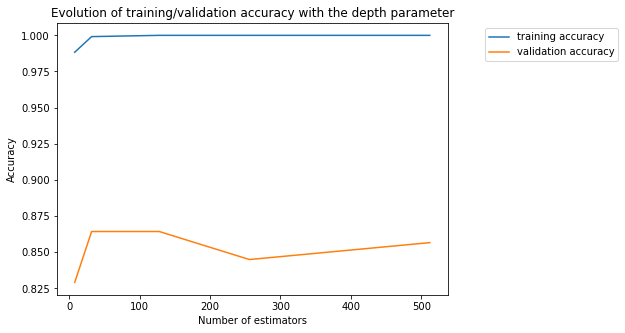

In [9]:
# Use only part of the data with the optimal depth
best_depth=int(rf_cv_results.sort_values(by="mean_te", ascending=False).head(1)['depth'])

# Use only part of the data with the tuned optimal depth
rf_cv_results_subset=rf_cv_results[rf_cv_results['depth']==best_depth]

# Plot
plt.figure(figsize=(7,5))

# Plot training/validation accuracy curves
plt.plot(rf_cv_results_subset["estimators"], rf_cv_results_subset["mean_tr"], label='training accuracy')
plt.plot(rf_cv_results_subset["estimators"], rf_cv_results_subset["mean_te"],  label='validation accuracy')

plt.xlabel('Number of estimators')
plt.legend(bbox_to_anchor=(1.45,1), loc="upper right")
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with the depth parameter")
plt.show()

If we instead look at the accuracy evolution for a model consisting of the optimal number of estimators versus the estimator depth, we can see that the validation accuracy improves with increasing depth. The model is overfitting quite heavily in this case and one choice could be to use smaller depth to trade the validation accuracy for a lower generalization error. 

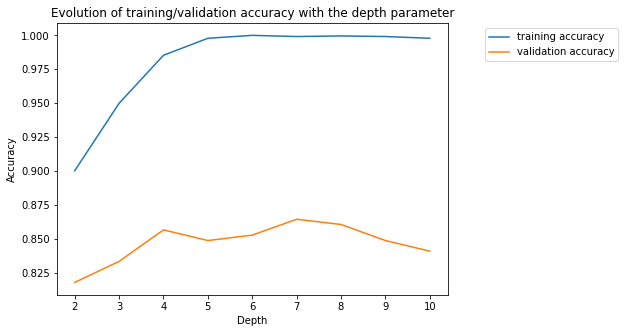

In [10]:
# From rf_cv_results, extract the number of estimators
best_number_estimators=int(rf_cv_results.sort_values(by="mean_te", ascending=False).head(1)['estimators'])

# Use only part of the data with the best number of estimators
rf_cv_results_subset=rf_cv_results[rf_cv_results['estimators']==best_number_estimators]

# Plot
plt.figure(figsize=(7,5))

# Plot training/validation accuracy curves
plt.plot(rf_cv_results_subset["depth"], rf_cv_results_subset["mean_tr"], label='training accuracy')
plt.plot(rf_cv_results_subset["depth"], rf_cv_results_subset["mean_te"],  label='validation accuracy')

plt.xlabel('Depth')
plt.legend(bbox_to_anchor=(1.45,1), loc="upper right")
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with the depth parameter")
plt.show()

In [11]:
# Print the best estimator
rf_gscv.best_estimator_.named_steps['rf']

RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=32)

In [12]:
from sklearn.metrics import classification_report

test_score_rf=rf_gscv.score(X_te, y_te)*100
%store test_score_rf
print('Test score', np.round(test_score_rf,3))

# Classification report
y_te_preds_rf = rf_gscv.predict(X_te)
%store y_te_preds_rf
print(classification_report(y_true=y_te, y_pred=y_te_preds_rf))

# Extract probabilities
prob_rf = rf_gscv.predict_proba(X_te)
%store prob_rf

Stored 'test_score_rf' (float64)
Test score 79.279
Stored 'y_te_preds_rf' (ndarray)
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        28
           1       0.00      0.00      0.00         9
           2       0.83      0.93      0.88        74

    accuracy                           0.79       111
   macro avg       0.51      0.54      0.52       111
weighted avg       0.73      0.79      0.76       111

Stored 'prob_rf' (ndarray)


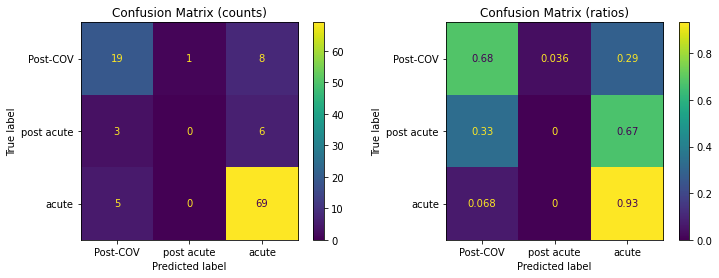

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, rf_gscv.predict(X_te), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, rf_gscv.predict(X_te), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

**Comment:** The model does not predict the smallest class 'post acute phase'. It correctly predicts the patients in the acute phase 95% of times and thise Post-COVID 75% of times. 67% of the post acute phase patients are classfied as being in the acute phase while 33% are classified as being 'Post-COVID'. \
PS. Sometimes when the Notebook is re-run, the model predicts very small amount of the post-acute phase patients, for exmaple one or two, but majority of them is classfied as being in teh acute phase of infection.

# Feature importance analysis

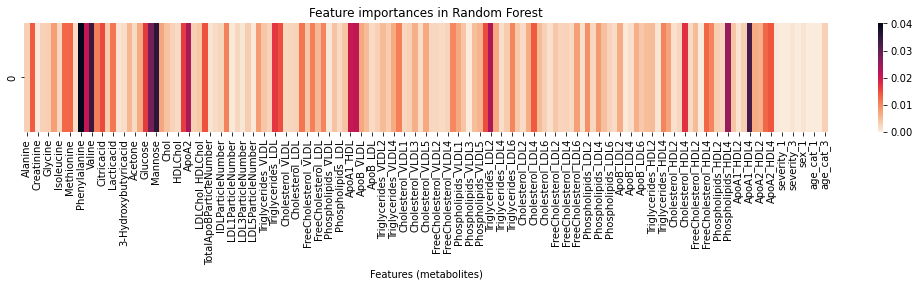

In [14]:
# Ranking of the features
feature_importances = rf_gscv.best_estimator_.named_steps['rf'].feature_importances_
feature_importances=pd.DataFrame(feature_importances, index=[X_tr.columns])

# Plot heatmap with the coefficients of the model
plt.figure(figsize=(18,2))
sns.heatmap(feature_importances.T, cmap = sns.cm.rocket_r)

plt.xlabel('Features (metabolites)')
# plt.ylabel('Categories')
plt.title("Feature importances in Random Forest")
plt.show()

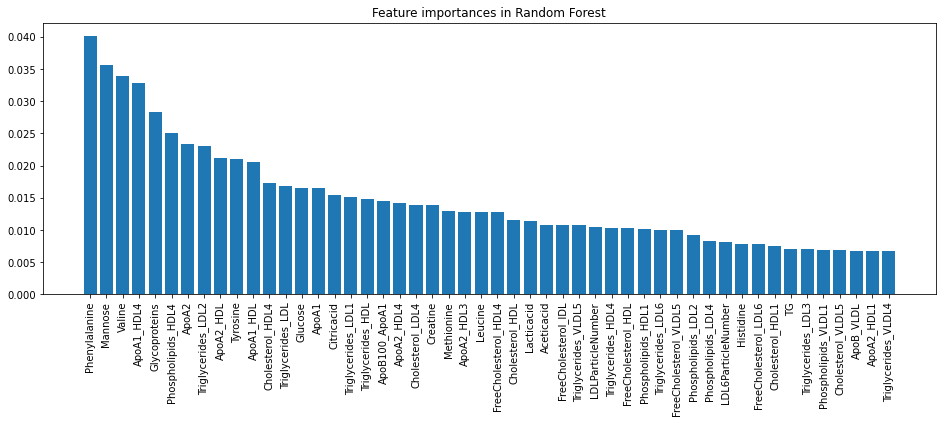

In [15]:
# Extract 50 most important features
feat_important=list(sum(feature_importances.sort_values(by=0, key=abs, ascending=False).index, ()))
feature_score=list(feature_importances.sort_values(by=0, key=abs, ascending=False).iloc[:,0])

plt.figure(figsize=(16,5))
plt.bar(feat_important[:50], feature_score[:50])
plt.title("Feature importances in Random Forest")
plt.xticks(rotation=90)
plt.show()

**Comment:** 
- The most important features according to the 'gini' impurity measure are: 'Phenylalanine', 'Mannose', 'ApoA1_HDL4', 'Phospholipids_HDL4', 'Glycoproteins',  'ApoA2', 'Triglycerides_HDL1', 'Valine', 'Isoleucine' etc. (I have noticed that these features change sligthly when re-running the notebook, it may be due to the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision.) This result may explain why the model does not predict the smallest class. Random forest is based on the decision tree and the post acute phase patients are too similar to either the acute phase or post-COVID patients in terms of the features that the decision tree uses to separate the dataset into three pure subsets. 
- It is noteworthy that the categorical features are not considered very important in the classification. 

# Grid search with cross-validation: 20 most important features

**Comment:** In this part, I will choose only the 20 most important features extracted above to see if this helps to fight the overfitting. reducing teh feature space may of course affect the accuracy, which is something I want to examine. 

In [16]:
# Create subsets of data
X_tr_feat=X_tr[feat_important[:20]]
X_te_feat=X_te[feat_important[:20]]

In [17]:
# Fit estimator
rf_gscv.fit(X_tr_feat, y_tr)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', None),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced'))]),
             param_grid={'rf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'rf__n_estimators': [8, 32, 128, 256, 512]},
             return_train_score=True, verbose=1)

In [18]:
# Collect results in a DataFrame
rf_cv_results = pd.DataFrame(
    {
        "estimators": rf_gscv.cv_results_["param_rf__n_estimators"],
        "depth": rf_gscv.cv_results_["param_rf__max_depth"],
        "mean_tr": rf_gscv.cv_results_["mean_train_score"],
        "mean_te": rf_gscv.cv_results_["mean_test_score"],
        "std_te": rf_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean "test" score
# i.e. the mean score on the 10 validation folds
rf_cv_results.sort_values(by="mean_te", ascending=False).head(10)

,estimators,depth,mean_tr,mean_te,std_te
32,128,8,1.000000,0.868000,0.034420
14,512,4,0.970175,0.864154,0.034498
16,32,5,0.987465,0.864000,0.035111
22,128,6,0.999567,0.860308,0.034144
27,128,7,1.000000,0.860308,0.038232
13,256,4,0.968008,0.860308,0.034144
19,512,5,0.995242,0.860154,0.034746
30,8,8,0.987024,0.860000,0.046481
39,512,9,1.000000,0.860000,0.035338
43,256,10,1.000000,0.856308,0.038054


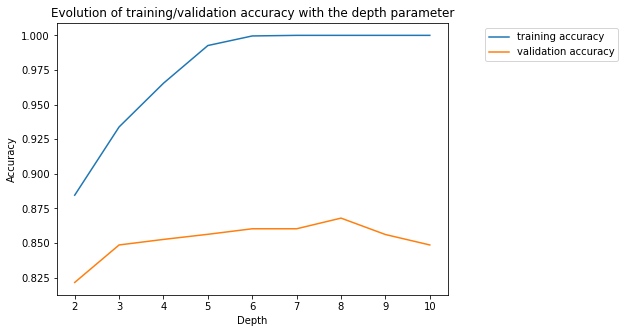

In [19]:
# From rf_cv_results, extract the number of estimators
best_number_estimators=int(rf_cv_results.sort_values(by="mean_te", ascending=False).head(1)['estimators'])

# Use only part of the data with the best number of estimators
rf_cv_results_subset=rf_cv_results[rf_cv_results['estimators']==best_number_estimators]

# Plot
plt.figure(figsize=(7,5))

# Plot training/validation accuracy curves
plt.plot(rf_cv_results_subset["depth"], rf_cv_results_subset["mean_tr"], label='training accuracy')
plt.plot(rf_cv_results_subset["depth"], rf_cv_results_subset["mean_te"],  label='validation accuracy')

plt.xlabel('Depth')
plt.legend(bbox_to_anchor=(1.45,1), loc="upper right")
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with the depth parameter")
plt.show()

In [20]:
# Print the best estimator
rf_gscv.best_estimator_.named_steps['rf']

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=128)

In [21]:
test_score_rf20=rf_gscv.score(X_te_feat, y_te)*100
%store test_score_rf20
print('Test score', np.round(test_score_rf20,3))

# Classification report
y_te_preds_rf20 = rf_gscv.predict(X_te_feat)
%store y_te_preds_rf20
print(classification_report(y_true=y_te, y_pred=y_te_preds_rf20))

# Extract probabilities
prob_rf20 = rf_gscv.predict_proba(X_te_feat)
%store prob_rf20

Stored 'test_score_rf20' (float64)
Test score 82.883
Stored 'y_te_preds_rf20' (ndarray)
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        28
           1       0.00      0.00      0.00         9
           2       0.85      0.96      0.90        74

    accuracy                           0.83       111
   macro avg       0.54      0.57      0.55       111
weighted avg       0.76      0.83      0.79       111

Stored 'prob_rf20' (ndarray)


C:\Users\marta\anaconda3\envs\adsml\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marta\anaconda3\envs\adsml\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marta\anaconda3\envs\adsml\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


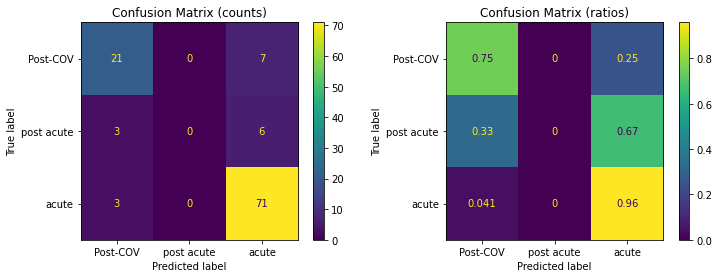

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, rf_gscv.predict(X_te_feat), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, rf_gscv.predict(X_te_feat), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

In [23]:
X_tr.shape

(257, 149)

**Comment:** The accuracy of the model decreased very sligtly when reducing the number of features from 149 to 20. The post-COVID patients or those in the acute phase of infection are classfied with recall very similar to one obtaiend with tuned logistic regression or the random forest fit on full data with all features. 

# SMOTE: Grid search with cross-validation: all features

In [24]:
# Oversample with SMOTE and random undersample for imbalanced dataset

from collections import Counter
from imblearn.over_sampling import SMOTE

# summarize class distribution
counter = Counter(y_tr)
print(counter)

# transform the dataset
sm = SMOTE(sampling_strategy = {2: 172, 0: 66, 1: 66})
X_tr_bal, y_tr_bal = sm.fit_resample(X_tr, y_tr)

# summarize the new class distribution
counter = Counter(y_tr_bal)
print(counter)

Counter({2: 172, 0: 66, 1: 19})
Counter({2: 172, 1: 66, 0: 66})


In [25]:
# Fit estimator
rf_gscv.fit(X_tr_bal, y_tr_bal)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', None),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced'))]),
             param_grid={'rf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'rf__n_estimators': [8, 32, 128, 256, 512]},
             return_train_score=True, verbose=1)

In [26]:
# Collect results in a DataFrame
rf_cv_results = pd.DataFrame(
    {
        "estimators": rf_gscv.cv_results_["param_rf__n_estimators"],
        "depth": rf_gscv.cv_results_["param_rf__max_depth"],
        "mean_tr": rf_gscv.cv_results_["mean_train_score"],
        "mean_te": rf_gscv.cv_results_["mean_test_score"],
        "std_te": rf_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean "test" score
# i.e. the mean score on the 10 validation folds
rf_cv_results.sort_values(by="mean_te", ascending=False).head(10)

,estimators,depth,mean_tr,mean_te,std_te
37,128,9,1.000000,0.918172,0.052630
27,128,7,0.999634,0.914946,0.050575
34,512,8,1.000000,0.914946,0.043488
33,256,8,1.000000,0.914731,0.046643
29,512,7,1.000000,0.908280,0.053914
24,512,6,0.998902,0.908172,0.049919
21,32,6,0.997805,0.904946,0.039353
38,256,9,1.000000,0.904946,0.046917
43,256,10,1.000000,0.901935,0.053739
44,512,10,1.000000,0.901720,0.047726


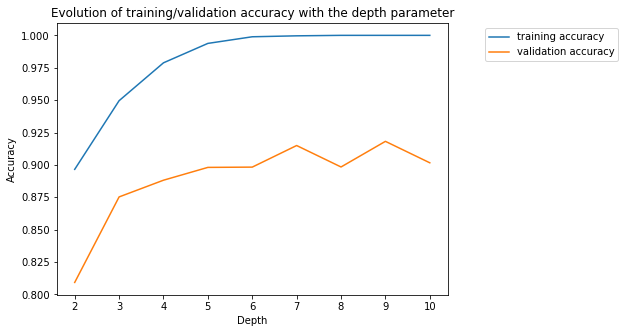

In [27]:
# From rf_cv_results, extract the number of estimators
best_number_estimators=int(rf_cv_results.sort_values(by="mean_te", ascending=False).head(1)['estimators'])

# Use only part of the data with the best number of estimators
rf_cv_results_subset=rf_cv_results[rf_cv_results['estimators']==best_number_estimators]

# Plot
plt.figure(figsize=(7,5))

# Plot training/validation accuracy curves
plt.plot(rf_cv_results_subset["depth"], rf_cv_results_subset["mean_tr"], label='training accuracy')
plt.plot(rf_cv_results_subset["depth"], rf_cv_results_subset["mean_te"],  label='validation accuracy')

plt.xlabel('Depth')
plt.legend(bbox_to_anchor=(1.45,1), loc="upper right")
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with the depth parameter")
plt.show()

In [28]:
# Print the best estimator
rf_gscv.best_estimator_.named_steps['rf']

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=128)

In [29]:
test_score_rf_smote=rf_gscv.score(X_te, y_te)*100
%store test_score_rf_smote
print('Test score', np.round(test_score_rf_smote,3))

# Classification report
y_te_preds_rf_smote = rf_gscv.predict(X_te)
%store y_te_preds_rf_smote
print(classification_report(y_true=y_te, y_pred=y_te_preds_rf_smote))

# Extract probabilities
prob_rf_smote = rf_gscv.predict_proba(X_te)
%store prob_rf_smote

Stored 'test_score_rf_smote' (float64)
Test score 80.18
Stored 'y_te_preds_rf_smote' (ndarray)
              precision    recall  f1-score   support

           0       0.73      0.68      0.70        28
           1       0.33      0.22      0.27         9
           2       0.86      0.92      0.89        74

    accuracy                           0.80       111
   macro avg       0.64      0.61      0.62       111
weighted avg       0.79      0.80      0.79       111

Stored 'prob_rf_smote' (ndarray)


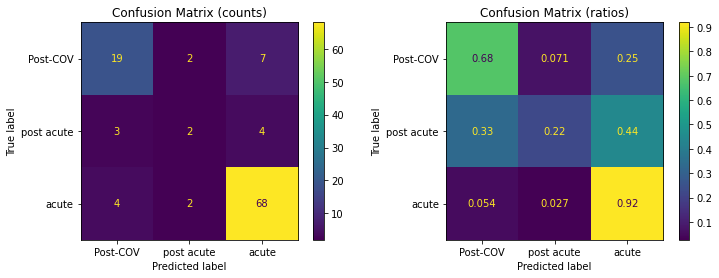

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, rf_gscv.predict(X_te), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, rf_gscv.predict(X_te), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

**Comment:** Oversampling using SMOTE does not really help the random forest model to predict teh post acute phase patients, either correctly or incorrectly. 